In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook'])
import sympy as smp
from skimage import color
from skimage import io
from scipy.fft import fftfreq
from scipy.fft import fft, ifft, fft2, ifft2

# Different Types of Fourier Transforms

## 1. Fourier Transform (Continuous time and frequency)

This occurs when the functional form of your time series is known analytically (i.e. you have a formula $x(t)=...$ for it) and goes from $-\infty$ to $\infty$

$$\hat{x}(f) = \int_{-\infty}^{\infty} x(t) e^{-2 \pi i f t} dt $$

**Solving Analytically (If Possible)**: Be careful giving proper information about your variables when you define them for sympy to work properly!

In [2]:
t, f = smp.symbols("t, f", real=True)


In [3]:
t, f = smp.symbols("t, f", real=True)
k = smp.symbols("k", real=True, positive=True)
x = smp.exp(-k * t**2) * k * t
x


k*t*exp(-k*t**2)

In [4]:
from sympy.integrals.transforms import fourier_transform


In [5]:
x_FT = fourier_transform(x, t, f)
x_FT


-I*pi**(3/2)*f*exp(-pi**2*f**2/k)/sqrt(k)

**Solving Numerically**: Sometimes sympy can't evaluate integrals analytically, in which case you'll need to use scipy

In [6]:
# Won't run
# x = smp.exp(-k * t**2) * smp.sin(k*t) * t**4
# fourier_transform(x, t, f)


In [7]:
from scipy.integrate import quad


Define function we want to take Fourier transform of and function to compute Fourier transform

In [8]:
def x(t, k):
    return np.exp(-k * t**2) * np.sin(k * t) * t**4


def get_x_FT(x, f, k):
    # scipy can not deal with complex numbers when it is taking integrals so compute real and complex component
    x_FT_integrand_real = lambda t: np.real(x(t, k) * np.exp(-2 * np.pi * 1j * f * t))
    x_FT_integrand_comp = lambda t: np.imag(x(t, k) * np.exp(-2 * np.pi * 1j * f * t))
    x_FT_real = quad(x_FT_integrand_real, -np.inf, np.inf)[0]
    x_FT_comp = quad(x_FT_integrand_comp, -np.inf, np.inf)[0]
    return x_FT_real + 1j * x_FT_comp


Get frequencies and fourier transform values

In [9]:
f = np.linspace(-4, 4, 100)
x_FT = np.vectorize(get_x_FT)(x, f, k=2)


Plot

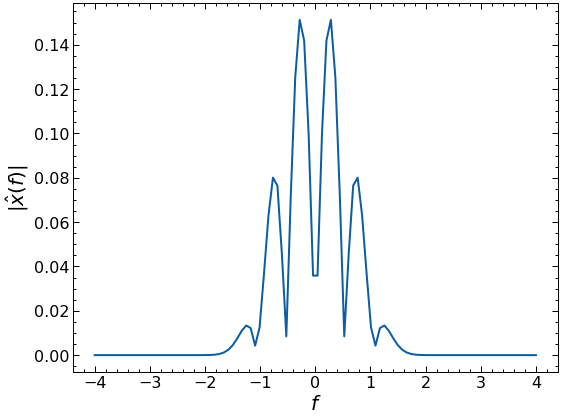

In [10]:
plt.figure()
plt.plot(f, np.abs(x_FT))
plt.ylabel("$|\hat{x}(f)|$", fontsize=20)
plt.xlabel("$f$", fontsize=20)
plt.tight_layout()
plt.show()


## 2. Fourier Series (Continuous Time (bounded), Discrete Frequency)
This occurs when the function $x(t)$ is bounded between times $0$ and $T$ (non-infinite)

$$\hat{x}(f_n) = \frac{1}{T} \int_{0}^{T} x(t) e^{-2 \pi i f_n t} dt $$

where $f_n = n/T$. 

In [11]:
# Consider now only between t=0 to t=1
t = smp.symbols("t", real=True)
k, n, T = smp.symbols("k, n, T", real=True, positive=True)
fn = n / T
x = smp.exp(-k * t)
x


exp(-k*t)

Compute the Fourier transform analytically:

In [12]:
x_FT = smp.integrate(
    1 / T * x * smp.exp(-2 * smp.pi * smp.I * fn * t), (t, 0, T)
).simplify()
x_FT


(exp(T*k + 2*I*pi*n) - 1)*exp(-T*k - 2*I*pi*n)/(T*k + 2*I*pi*n)

In [13]:
smp.Abs(x_FT).simplify()


sqrt(exp(2*T*k) - exp(T*k - 2*I*pi*n) - exp(T*k + 2*I*pi*n) + 1)*exp(-T*k)/sqrt(T**2*k**2 + 4*pi**2*n**2)

Convert to a numerical function so the values can be extracted numerically and plotted:

In [14]:
get_FT = smp.lambdify(
    [k, T, n], x_FT
)  # turn sympy function into a python function that returns values
ns = np.arange(0, 20, 1)  # while f_n = n/T plug different values of n
xFT = get_FT(k=1, T=4, n=ns)


Plot:

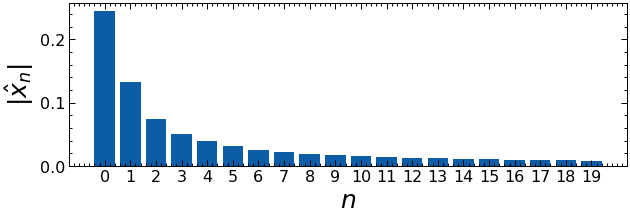

In [15]:
plt.figure(figsize=(10, 3))
plt.bar(ns, np.abs(xFT))
plt.xticks(ns)
plt.ylabel("$|\hat{x}_n|$", fontsize=25)
plt.xlabel("$n$", fontsize=25)
plt.show()


If it can't be done analytically, need to use scipy like before. Consider

$$x(t) = e^{-k t^2} \sin(kt) / t  \hspace{10mm} k=2, T=4$$

In [16]:
def x(t, k):
    return np.exp(-k * t**2) * np.sin(k * t) / t


def get_x_FT(x, n, k, T):
    x_FT_integrand_real = lambda t: np.real(
        x(t, k) * np.exp(-2 * np.pi * 1j * (n / T) * t)
    )
    x_FT_integrand_comp = lambda t: np.imag(
        x(t, k) * np.exp(-2 * np.pi * 1j * (n / T) * t)
    )
    x_FT_real = quad(x_FT_integrand_real, 0, T)[0]
    x_FT_comp = quad(x_FT_integrand_comp, 0, T)[0]
    return x_FT_real + 1j * x_FT_comp


Compute values of $n$ in $f_n=n/T$ and then $\hat{x}_n$ itself using the function above:

In [17]:
ns

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [18]:
ns = np.arange(0, 20, 1)
xFT = np.vectorize(get_x_FT)(x, ns, k=2, T=4)

Plot

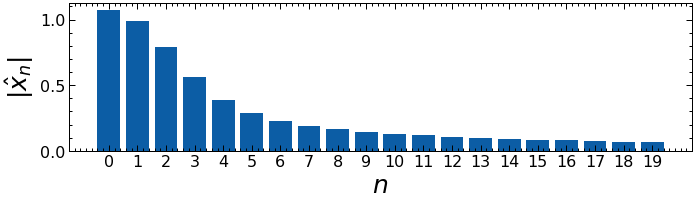

In [19]:
plt.figure(figsize=(10,3))
plt.bar(ns, np.abs(xFT))
plt.xticks(ns)
plt.ylabel('$|\hat{x}_n|$', fontsize=25)
plt.xlabel('$n$', fontsize=25)
plt.tight_layout()
plt.show()

## 3. Discrete Fourier Transform (Discrete Time, Discrete Frequency)

Here we consider a discrete time series $x_t$ that's measured for a finite amount of time ($N$ measurements over a time $T$ implies $N\Delta t = T$). The Fourier transform here is **defined** as

$$\hat{x}(f_n) = \sum_{k=0}^{N-1} x_t e^{-2 \pi i f_n (k \Delta t)} \hspace{10mm} f_n=\frac{n}{N\Delta t} \hspace{10mm} n=0,1,2...,N-1 $$

where $f_n$ are the so-called Fourier frequencies. The notation can be simplfied as

$$\hat{x}_n = \sum_{k=0}^{N-1} x_t e^{-2 \pi i kn/N} \hspace{10mm} k=0,1,2...,N-1$$


Note we get $\hat{x}_n = \hat{x}_{n \pm N} = \hat{x}_{n \pm 2N} = ...$ with this definition. With this we can restrict ourselves from $n=0$ to $n=N-1$ and not lose any information OR we can also restrict ourselves to 

* In the case that $N$ is even, $n=-N/2$ to $n=N/2-1$ 
* In the case that $N$ is odd, $n=-(N-1)/2$ to $(N-1)/2$

This is precisely what scipy does, returning an array $\hat{x}_n$ corresponding to the frequencies

`f = [0, 1, ...,   N/2-1,     -N/2, ..., -1] / (dt*N)   if N is even`

`f = [0, 1, ..., (N-1)/2, -(N-1)/2, ..., -1] / (dt*N)   if N is odd`

Why does it do this? Well typically one deals with real time series $x_t$, and there's a handy identity

$$\hat{x}_n = \hat{x}_{-n}^*$$

so one only needs to look at the first half of the frequencies to know everything about the Fourier transform $\hat{x}_n$.



In [20]:
T = 40 #seconds
N = 100 #measurements
t = np.linspace(0, T, N)
dt = np.diff(t)[0]

Look at a couple particular frequencies

In [21]:
f1 = 20/(N*dt)
f2 = 10/(N*dt)
f3 = (10+5*N)/(N*dt)

Get a few time series:

In [22]:
x1 = np.sin(2*np.pi*f1*t) + 0.3*np.sin(2*np.pi*f2*t) + 0.3*np.random.randn(len(t))
x2 = np.sin(2*np.pi*f2*t)+ 0.1*np.random.randn(len(t))
x3 = np.sin(2*np.pi*f3*t)+ 0.1*np.random.randn(len(t))

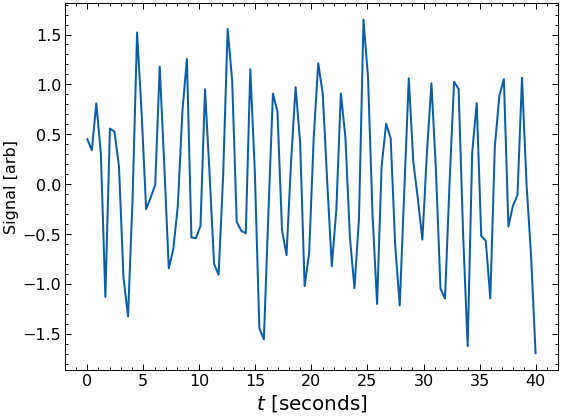

In [23]:
plt.figure()
plt.plot(t, x1)
plt.xlabel('$t$ [seconds]', fontsize=20)
plt.ylabel('Signal [arb]')
plt.tight_layout()
plt.show()

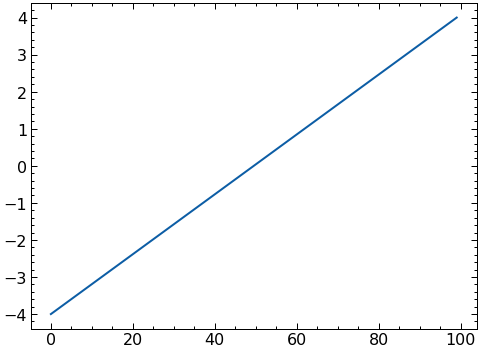

In [24]:
plt.plot(f)

In [25]:
f = fftfreq(len(t), np.diff(t)[0])
x1_FFT = fft(x1)

Plot the first half of the spectrum (for $x(t)$ real, all information is contained in the first half)

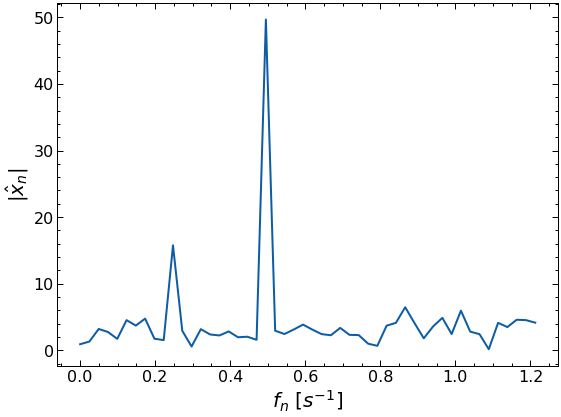

In [26]:
plt.figure()
plt.plot(f[:N//2], np.abs(x1_FFT[:N//2]))
plt.xlabel('$f_n$ [$s^{-1}$]', fontsize=20)
plt.ylabel('|$\hat{x}_n$|', fontsize=20)
plt.tight_layout()
plt.show()

Demonstrate that $\hat{x}_n = \hat{x}_{n+5N}$ here:

In [27]:
print(f2)
print(f3)

0.24750000000000003
12.6225


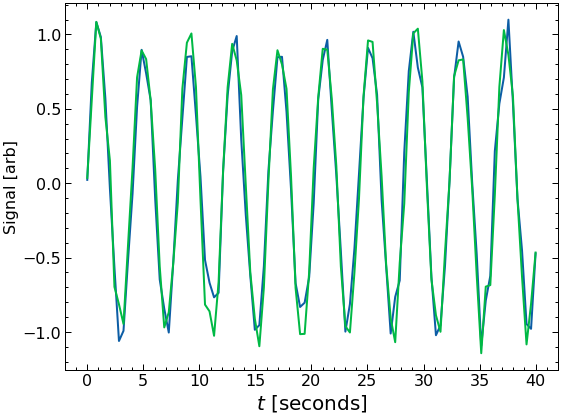

In [28]:
plt.figure()
plt.plot(t,x2)
plt.plot(t,x3)
plt.xlabel('$t$ [seconds]', fontsize=20)
plt.ylabel('Signal [arb]')
plt.tight_layout()
plt.show()

In [29]:
x2_FFT = fft(x2)
x3_FFT = fft(x3)

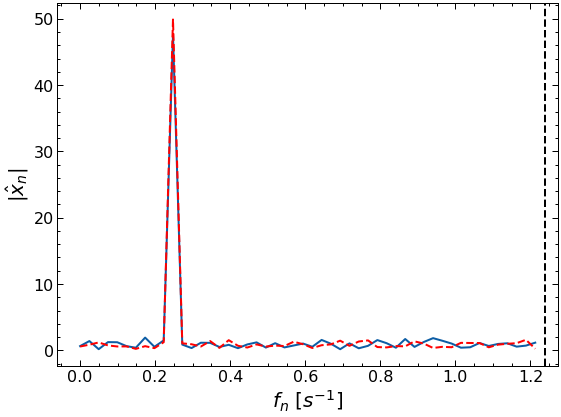

In [30]:
plt.figure()
plt.plot(f[:N//2], np.abs(x2_FFT[:N//2]), label='$x_2$')
plt.plot(f[:N//2], np.abs(x3_FFT[:N//2]), 'r--', label='$x_3$')
plt.axvline(1/(2*dt), ls='--', color='k')
plt.xlabel('$f_n$ [$s^{-1}$]', fontsize=20)
plt.ylabel('|$\hat{x}_n$|', fontsize=20)
plt.tight_layout()
plt.show()

A little bit of 2D Fourier transform stuff:

In [31]:
img = io.imread('images/flower.png')
img = img[:,:,:-1]
img = color.rgb2gray(img)

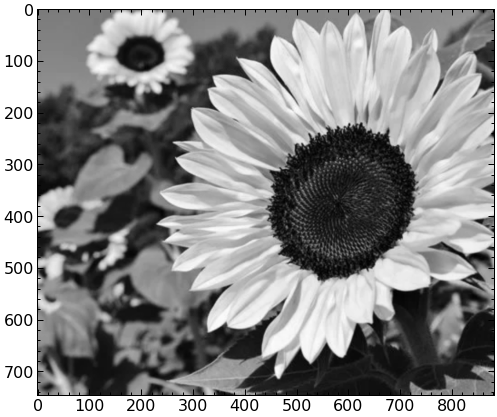

In [32]:
plt.figure()
plt.imshow(img, cmap='gray')
plt.tight_layout()
plt.show()

In [33]:
img_FT = fft2(img)
fy = np.fft.fftfreq(img.shape[0],d=10) #suppose the spacing between pixels is 10mm, for example
fx = np.fft.fftfreq(img.shape[1],d=10)

In [34]:
print('{:.2f} correponds to fx={:.6f} and fy={:.6f}'.format(img_FT[10,20], fx[20], fy[10]))

-83.17+1871.49j correponds to fx=0.002268 and fy=0.001340


Analogous to 1D, the zero frequency terms correspond to low-order corners of the array, the positive frequency terms in the first half, the nyquist frequency in the middle, and the negative frequencies in the second half.

* If $M(x,y)$ (the image) contains real values then $\hat{M}(f_x, f_y)$ is symmetric WRT to the middle of each axis. 

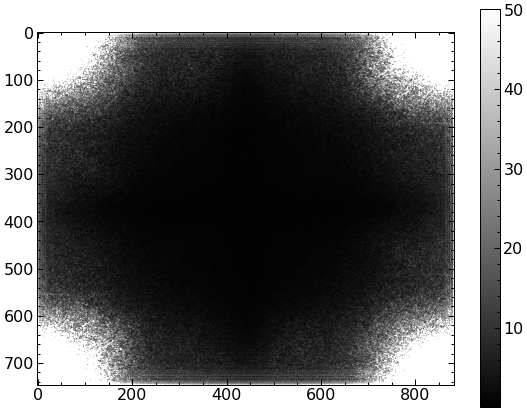

In [35]:
plt.figure()
plt.imshow(np.abs(img_FT), cmap='gray', vmax=50)
plt.colorbar()
plt.tight_layout()
plt.show()

Remove low frequencies

In [36]:
img_FT_alt = np.copy(img_FT)
img_FT_alt[-2:] = 0 
img_FT_alt[:,-2:] = 0 
img_FT_alt[:2] = 0 
img_FT_alt[:,:2] = 0 

In [37]:
img_alt = np.abs(ifft2(img_FT_alt))

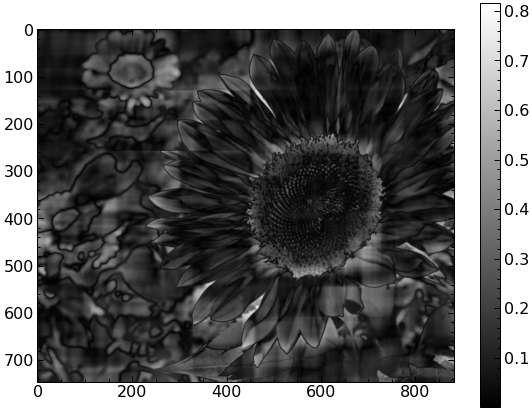

In [38]:
plt.figure()
plt.imshow(img_alt, cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.show()

For more advanced image processing see https://scikit-image.org/